# Implicit priors with regularized Gaussian distributions

In this notebook, we demonstrate how to use regularized Gaussian distributions from [[1]](https://iopscience.iop.org/article/10.1088/1361-6420/acf9c5) in CUQIpy.


Text(0.5, 1.0, 'Data')

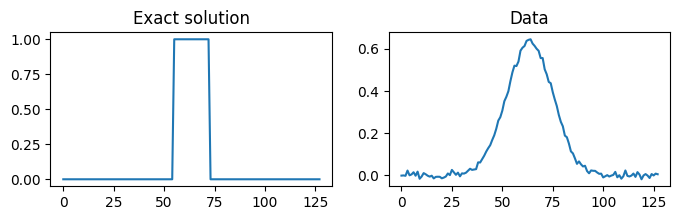

In [1]:
# Load modules and set-up test problem
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from cuqi.testproblem import Deconvolution1D
from cuqi.distribution import Gaussian, Gamma, ImplicitRegularizedGaussian, ImplicitRegularizedGMRF, JointDistribution
from cuqi.problem import BayesianProblem
from cuqi.sampler import RegularizedLinearRTO, Gibbs, Conjugate

from cuqi.solver import ProximalL1, ProjectNonnegative, ProjectBox

n = 128
A, y_data, info = Deconvolution1D.get_components(dim=n, phantom='square')

plt.figure(figsize = (8,2))
plt.subplot(1,2,1)
info.exactSolution.plot()
plt.title("Exact solution")

plt.subplot(1,2,2)
y_data.plot()
plt.title("Data")

## Implicit constraints and regularization

Let $A$ be a linear forward operator and consider the Gaussian likelihood function $L(y\,|\, x) \propto \exp\left(-\frac{1}{2}\|Ax-y\|^2_{\Sigma}\right)$ and Gaussian prior $\pi(x)\propto \exp\left(-\frac{1}{2}\|Lx-c\|^2_{\Lambda}\right)$.

The resulting posterior $\pi(x\,|\, y) \propto L(y\,|\, x)\pi(x) \propto \exp\left(-\frac{1}{2}\|Ax-y\|^2_{\Sigma} - \frac{1}{2}\|Lx-c\|^2_{\Lambda}\right)$ is a Gaussian distribution, from which can be sampled by solving the randomized linear least squares problem:

$
\min_{x \in \mathbb{R}^n} \left\{ \frac{1}{2}\|Ax-\hat{b}\|_\Sigma^2  + \frac{1}{2}\|Lx-\hat{c}\|_\Lambda^2\right\},
$

where $\hat{b}$ and $\hat{c}$ are random perturbations from $\text{Normal}(b, \Sigma^{-1})$ and $\text{Normal}(b, \Lambda^{-1})$ respectively.

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct sampling of Gaussian posterior. Only works for small-scale problems with dim<=2000.
No burn-in needed for direct sampling.
 Sample 1000 / 1000
Elapsed time: 0.19808316230773926
Plotting results


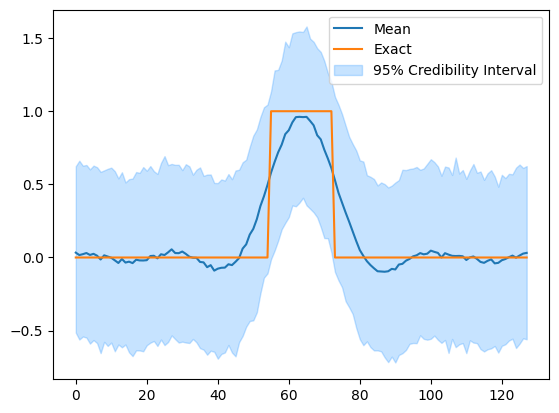

In [2]:
x  = Gaussian(np.zeros(n), 0.1)
y  = Gaussian(A@x, 0.001)
BP = BayesianProblem(y, x).set_data(y=y_data)
BP.UQ(exact=info.exactSolution)

Constraints and regularization can be added to randomized linear least squares problem by adding a suitable penalization function $R(x)$.
The resulting objective function from the regularized, randomized linear least squares problem can be split into two terms:

$
\min_{x \in \mathbb{R}^n} \left\{ \underbrace{\frac{1}{2}\|Ax-\hat{b}\|_\Sigma^2}_{\text{Gaussian likelihood}}  + \underbrace{\frac{1}{2}\|Lx-\hat{c}\|_\Lambda^2 + R(x)}_{\text{Implicit regularized Gaussian prior}}\right\}.
$

The Gaussian likelihood term is the same as in the unregularized problem, however, the prior term now consists of both a randomized linear least squares error term from the original Gaussian prior and the regularization term.
These two prior terms are combined into the `ImplicitRegularizedGaussian` distribution as follows:

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Regularized LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 25.415937185287476
Plotting results


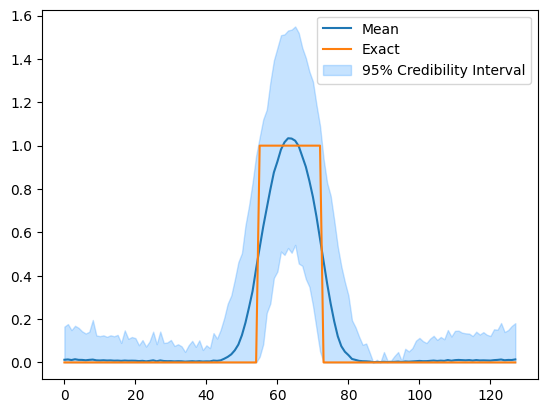

In [3]:
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegative")
y  = Gaussian(A@x, 0.001)
BP = BayesianProblem(y, x).set_data(y=y_data)
BP.UQ(exact=info.exactSolution)

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Regularized LinearRTO sampler.
burn-in: 20%


Sample 1200 / 1200
Elapsed time: 25.738999128341675
Plotting results


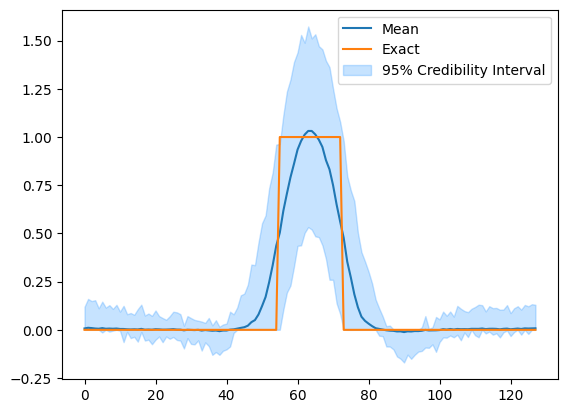

In [4]:
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, proximal = lambda z, s : ProximalL1(z, 6*s))
y  = Gaussian(A@x, 0.001)
BP = BayesianProblem(y, x).set_data(y=y_data)
BP.UQ(exact=info.exactSolution)

Note that these prior distributions are only defined implicitely and can only be sampled from after being combined with a likehood. Therefore, one cannot sample just form the implicit regularized Gaussian

In [5]:
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegative")
_ = x.sample()

ValueError: There is no known way of efficiently sampling from a implicit regularized Gaussian distribution.

## Creating an implicit regularized Gaussian distribution

There are different ways of construction Implicit Regularized Gaussian distributions:
- For certain pre-implemented constraints, one can specify the constraint a simple string like "nonnegative" or "box".

- For general constraints on $C$, one can specify a projector function $\text{projector}(z) = \argmin_{x \in C} \left\{\|x-z\|_2\right\}$.

- For general regularization functions $R$, one has to specify the proximal operator $\text{prox}_R(z, s) = \argmin_{x \in \mathbb{R}^n} \left\{\|x-z\|^2_2 + s\ R(x)\right\}$.

Note that constraints cannot be supplied using an indicator function, due to the algorithm used for solving the regularized linear least squares problem.

The following code shows various ways of creating implicit regularized Gaussian distributions.

In [6]:
# The following are equivalent*
# Nonnegativity constraint
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegative")
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "NN")
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegativity")
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, projector  = ProjectNonnegative)
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, projector  = lambda z : np.maximum(z, 0))
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, proximal   = lambda z, s : np.maximum(z, 0))
# * Those specified using the constraint argument can be used in some hierarchical models

# The following are equivalent
# Box ([0,1]^n) constraint
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "box")
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, projector  = ProjectBox)
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, projector  = lambda z : np.minimum(np.maximum(z, 0), 1))
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, proximal   = lambda z, s : np.minimum(np.maximum(z, 0), 1))


# l1 (R(x) = \|x\|_1) regularization
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, proximal   = ProximalL1)
# l1 (R(x) = gamma*\|x\|_1) regularization
gamma = 10
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, proximal   = lambda z, s : ProximalL1(z, gamma*s))

Alongside the `ImplicitRegularizedGaussian` distribution, there is also the `ImplicitRegularizedGMRF` distribution, which is initialized in a similar manner, but with the `Gaussian` arguments replaced by arguments of `GMRF`.

In [7]:
x = ImplicitRegularizedGMRF(np.zeros(n), lambda d:d, constraint = "nonnegative")

## Regularized Linear RTO (Randomize-then-Optimize)
Once the implicit regularized Gaussian prior is combined with a Gaussian likelihood, samples can be obtained by solving the regularized, randomized linear least squares problem. This sampler is implemented as the `RegularizedLinearRTO` sampler, which uses the FISTA algorithm  from [[2]](https://epubs.siam.org/doi/abs/10.1137/080716542) to solve the regularized linear least squares problem. 

Sample 1100 / 1100


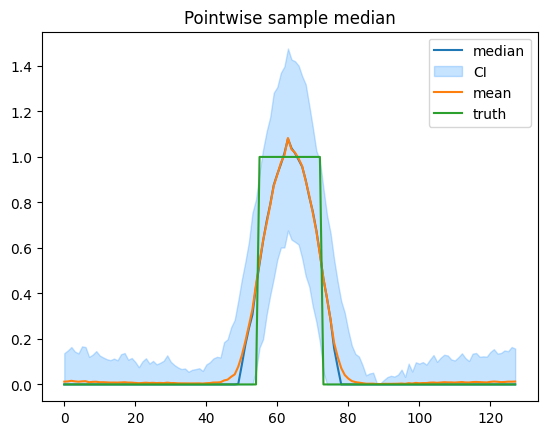

In [8]:
x  = ImplicitRegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegative")
y  = Gaussian(A@x, 0.001)

joint = JointDistribution(x, y)
posterior = joint(y=y_data)

sampler = RegularizedLinearRTO(posterior,
                                maxit=100,       # Maximum number of iterations for underlying FISTA solver
                                stepsize = 5e-4, # Stepsize for underlying FISTA solver, or set to "automatic" to automatically select the stepsize
                                abstol=1e-10)    # Absolute error tolerance for stopping criteria of underlying FISTA solver
samples = sampler.sample(1000, 100)

plt.figure()
samples.plot_median() # Median is a more representative point-estimate for this distribution
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["median", "CI", "mean", "truth"])
plt.show()

## Nonnegative Hierarchical Gibbs sampler

In the nonnegativity constrainted setting, Gibbs samplers can still be derived for simple hierarchical models like:
$$
x\,|\, \lambda, \delta, b = \min_{x \in \mathbb{R}_{\geq 0}^{n}} \left\{\frac{\lambda}{2}\|Ax-\hat{b}\|_2^2 + \frac{\delta}{2}\|Lx-\hat{c}\|_2^2\right\},
$$
$$
\text{with } \hat{b} \sim \text{Normal}(b, \lambda^{-1}I) \text{ and } \hat{c} \sim \text{Normal}(0, \delta^{-1}I),
$$
$$
\lambda \sim \text{Gamma}(\alpha_{\lambda}, \beta_{\lambda}),
$$
$$
\delta \sim \text{Gamma}(\alpha_{\delta}, \beta_{\delta}).
$$

For a detailed derivation, see [[3]](https://epubs.siam.org/doi/abs/10.1137/18M1234588) or [[4]](https://epubs.siam.org/doi/full/10.1137/22M150695X)

To use this Gibbs sampler in CUQIpy, the constraint needs to be specified using `constraint = "nonnegative"`, as in the following example:

Warmup 200 / 200
Sample 1000 / 1000


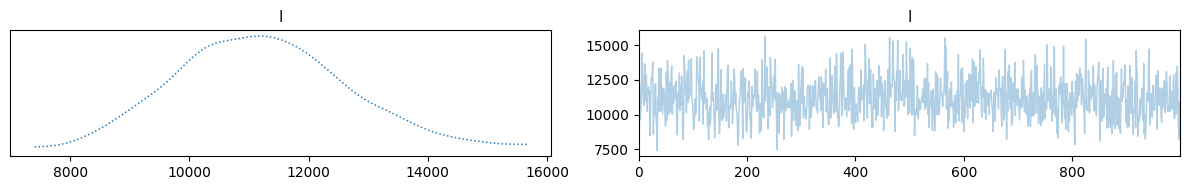

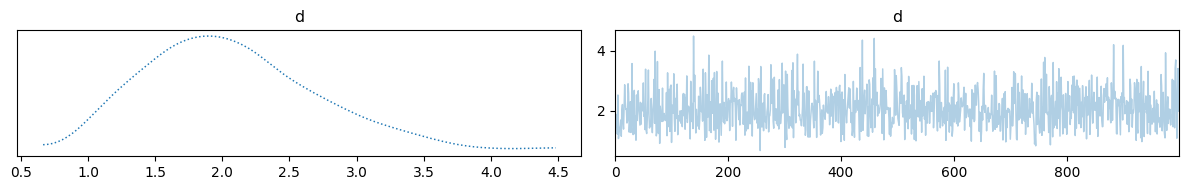

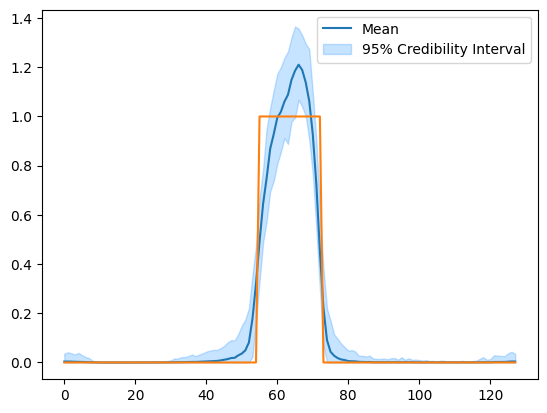

In [9]:
d = Gamma(1, 1e-4)
l = Gamma(1, 1e-4)
x = ImplicitRegularizedGMRF(np.zeros(n), prec = lambda d:d, constraint = "nonnegative")
y = Gaussian(A@x, prec = lambda l:l)

# Combine into a joint distribution
joint = JointDistribution(d, l, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'd': Conjugate,
    'l': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

## Future features
The following related features might be implemented in the future:
- More constraints, e.g., simplex, and regularization options, e.g., anisotropic total variation
- Multiple solvers
- Gibbs samplers for regularization of the form $R(x) = \gamma \|Lx\|_1$

## References
[1]: [Everink, J. M., Dong, Y., & Andersen, M. (2023). Sparse bayesian inference with regularized gaussian distributions. Inverse Problems.](https://iopscience.iop.org/article/10.1088/1361-6420/acf9c5)

[2]: [Beck, A., & Teboulle, M. (2009). A fast iterative shrinkage-thresholding algorithm for linear inverse problems. SIAM journal on imaging sciences, 2(1), 183-202.](https://epubs.siam.org/doi/abs/10.1137/080716542)

[3]: [Bardsley, J. M., & Hansen, P. C. (2020). MCMC algorithms for computational UQ of nonnegativity constrained linear inverse problems. SIAM Journal on Scientific Computing, 42(2), A1269-A1288.](https://epubs.siam.org/doi/abs/10.1137/18M1234588)

[4]: [Everink, J. M., Dong, Y., & Andersen, M. S. (2023). Bayesian inference with projected densities. SIAM/ASA Journal on Uncertainty Quantification, 11(3), 1025-1043.](https://epubs.siam.org/doi/full/10.1137/22M150695X)